**Initialization**

In [1]:
import numpy as np

import datetime as dt

%tensorflow_version 2.x
import tensorflow as tf

import matplotlib.pyplot as plt

# **Task 1: Data set**

The Cifar10 dataset comes directly in a two-part dataset for training and test data. The training dataset contains 50000 image-label pairs and the test dataset 10000 image-label pairs. The labels are displayed as numbers from 0 to 9. Among other things in the following code snippet these numbers are mapped to their string label class names. The images in the datasets come up with a fixed shape of 32 x 32 x 3. Thus no resizing is necessary. 

Additionally, some example images of the dataset are displayed with the corresponding string label class name.

170500096/170498071 [==============================] - 2s 0us/step
Training inputs shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test inputs shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


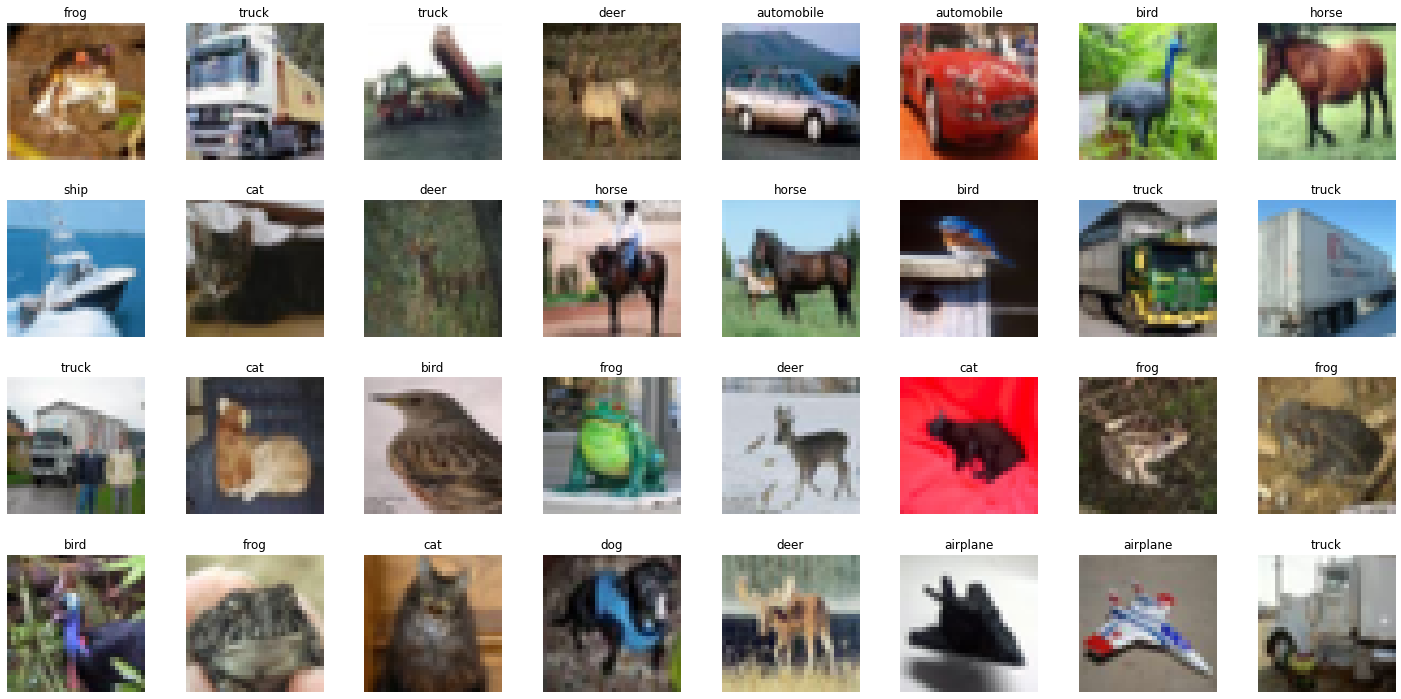

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i][-1]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Input pipeline

In [3]:
batch_size = 128

# Creates tensorflow datasets for the training and test data.
training_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
training_dataset = training_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))  # tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors.
test_dataset = test_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))     
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
training_dataset = training_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

# **Task 2.2: Model - DenseNet**

**Class TransitionLayer**

Implementation of a callable Transition Layer for the DenseNet. 

This one should include:

*   Concolutional Layer
*   Batch Normalization
*   Activation Function ReLu
*   Pooling Layer (AveragePooling)













In [4]:
# Description: The class TransitionLayer describes a transition layer of a DenseNet.
class TransitionLayer(tf.keras.layers.Layer): 
  
  def __init__(self, num_channels_trans_layer):
    super(TransitionLayer, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filters = num_channels_trans_layer,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
    self.activ_1 = tf.keras.activations.relu                         
    self.aver_pool_1 = tf.keras.layers.AveragePooling2D(strides=(2, 2), padding = 'same')   #Without strides?

  # Description: This function conducts one forward-step of the transition layer. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls of the residual block)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.aver_pool_1(x)
    return x

**Class ConvolutionalBlock**

This class is needed to create a Dense Block. It includes a bottleneck layer, which is needed to get a lower number of parameters and so a faster network, and a convolutional layer. When calling, the forward step is conducted and the output of the convolutional layer is concatenate with the input of the bottleneck layer. The result of the concatenation is the output of the convolutional block.

In [5]:
# Description: The class ConvolutionalBlock describes a convolutional block of a DenseBlock.
#              @init variables: num_filter
#              @class variables: -
#              @object variables: batch_norm_1, activ_1, conv_1, conv_2, batch_norm_2, activ_2, dropout, concat
#              @functions: call
class ConvolutionalBlock(tf.keras.layers.Layer): 
  
  def __init__(self, num_filter):
    super(ConvolutionalBlock, self).__init__()

    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
    self.activ_1 = tf.keras.activations.relu                
    self.conv_1 = tf.keras.layers.Conv2D(filters = num_filter,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        
    self.conv_2 = tf.keras.layers.Conv2D(filters = num_filter,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         
    self.activ_2 = tf.keras.activations.relu
    self.dropout = tf.keras.layers.Dropout(rate = 0.1)          
    self.concat = tf.keras.layers.Concatenate()               

  # Description: This function conducts one forward-step of the convolutional block. Therefore the block output
  #              is concatenated with the block input. The python decorator @tf.function is used to bundle multiple 
  #              computations into one computational graph.
  #              @parameters: block_input, training (to differ between training and test calls, which is needed for the dropout layer)
  #              @returns: block_output
  @tf.function
  def call(self, block_input, training = True):
    x = self.batch_norm_1(block_input, training)
    x = self.activ_1(x)
    x = self.conv_1(x)
    x = self.conv_2(x) 
    x = self.batch_norm_2(x, training)
    x = self.activ_2(x)
    x = self.dropout(x, training)

    block_output = self.concat([x, block_input]) 
    return block_output

**Class DenseBlock**

Implementation of the Dense Blocks for the DenseNet. They include as many convolutional blocks as the length of the list_num_filter. The parameters in list_num_filters are needed to create the convolutional blocks. Each entry in the list list_num_filters, represents the amount of filters of the second layer of the convolutional block.

In [6]:
# Description: The class DenseBlock describes a dense block of a DenseNet.
#              @init variables: list_num_filter
#              @class variables: -
#              @object variables: convolutional_blocks
#              @functions: call
class DenseBlock(tf.keras.layers.Layer): 

  def __init__(self, list_num_filter):
    super(DenseBlock, self).__init__()

    self.convolutional_blocks = []
    for num_filter in list_num_filter:
      self.convolutional_blocks.append(ConvolutionalBlock(num_filter))

  # Description: This function conducts one forward-step of the dense block. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test, which is needed for the dropout layer in the convolutional blocks)
  #              @returns: (output) x
  @tf.function
  def call(self, x, training = True):
    for conv_block in self.convolutional_blocks:
      x = conv_block(x, training)
    return x

**Class DenseNet**
This class is in this case our model itself. It creates a densetly connected network (DenseNetwork). This network includes a with initialization defined number of dense blocks (num_dense_blocks). Between the dense blocks there are initalize transition layers. The input layer is a normal convolution layer and the output layer after the last dense block is a dense layer.

In [7]:
# Description: The class DenseNet describes a dense convolutional neural network with a feature extractor and a classifier.
#              @init variables: num_dense_blocks, list_num_filter, growth_rate
#              @class variables: -
#              @object variables: conv_1, batch_norm_1, activ_1, dropout_1, dense_blocks_and_trans_layers, last_dense_block,
#                                 global_pool, dropout_2, output_layer
#              @functions: call
class DenseNet(tf.keras.Model): 
  
  def __init__(self, num_dense_blocks, list_num_filter, growth_rate):
    super(DenseNet, self).__init__()
    num_conv_blocks = len(list_num_filter)
    # Feature extractor
    self.conv_1 = tf.keras.layers.Conv2D(filters = 32,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   
                                         bias_initializer = 'zeros',                                 
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        
                                         input_shape = (32, 32, 3))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
    self.activ_1 = tf.keras.activations.relu
    self.dropout_1 = tf.keras.layers.Dropout(rate = 0.6)    

    num_channels_trans_layer = growth_rate * num_conv_blocks
    self.dense_blocks_and_trans_layers = []
    for _ in range(num_dense_blocks - 1):                         # The last dense block does not need a transition layer -> num_dense_blocks - 1 
      self.dense_blocks_and_trans_layers.append(DenseBlock(list_num_filter))   
      self.dense_blocks_and_trans_layers.append(TransitionLayer(num_channels_trans_layer)) 
    self.last_dense_block = DenseBlock(list_num_filter)

    # Classifier
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dropout_2 = tf.keras.layers.Dropout(rate = 0.6)                                                  
    self.output_layer = tf.keras.layers.Dense(10, 
                                              activation=tf.keras.activations.softmax)


  # Description: This function conducts one forward-step of the Dense CNN. 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training (to differ between training and test calls, which is needed for the dropout layer)
  #              @returns: (prediction) x
  @tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.dropout_1(x, training)

    for i in self.dense_blocks_and_trans_layers:
      x = i(x, training)
    x = self.last_dense_block(x, training)

    x = self.global_pool(x)
    x = self.dropout_2(x, training)
    x = self.output_layer(x)
    return x

# **Task 3: Training and Analysis**

To improve the network much more, we should have break up the training when it achieves 85% test accuracy. Because of time we could have implement this, but not running the whole programm again. So we decided to leave our code as it shows their results here.

In [8]:
# Description: This function conducts a forward-step and the backpropagation of a CNN. It does not matter whether the CNN is a ResNet or 
#              a DenseNet (this is defined by the parameter model). Additionally, the average training loss and accuracy is determined.
#              @parameters: model, training_data, loss_fn, optimizer, training (to differ between training and test calls of the CNN)
#              @returns: training_loss, training_accuracy
#@tf.function
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = model(input, training)
      current_training_loss = loss_fn(target, prediction)+ tf.math.reduce_sum(model.losses)   
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))  
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy


# Description: This function determines the average test loss and accuracy of a CNN. It does not matter 
#              whether the CNN is a ResNet or a DenseNet (this is defined by the parameter model).
#              @parameters: model, test_data, loss_fn, training (to differ between training and test calls of the CNN)
#              @returns: test_loss, test_accuracy
#@tf.function
def test(model, test_data, loss_fn, training = False):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = model(input, training)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

Epoch 0
2020-12-09 15:47:26.828997
Training accuracy: 0.2517543158567775
Test accuracy: 0.1475474683544304
Epoch 1
2020-12-09 15:49:06.443023
Training accuracy: 0.390565057544757
Test accuracy: 0.2797666139240506
Epoch 2
2020-12-09 15:50:29.533085
Training accuracy: 0.4777773337595908
Test accuracy: 0.3192246835443038
Epoch 3
2020-12-09 15:51:52.717358
Training accuracy: 0.5351742327365729
Test accuracy: 0.35986946202531644
Epoch 4
2020-12-09 15:53:16.148741
Training accuracy: 0.5818174552429667
Test accuracy: 0.4810126582278481
Epoch 5
2020-12-09 15:54:39.255271
Training accuracy: 0.6137827685421995
Test accuracy: 0.4742879746835443
Epoch 6
2020-12-09 15:56:02.126526
Training accuracy: 0.6419876918158568
Test accuracy: 0.5168117088607594
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
__________________________________

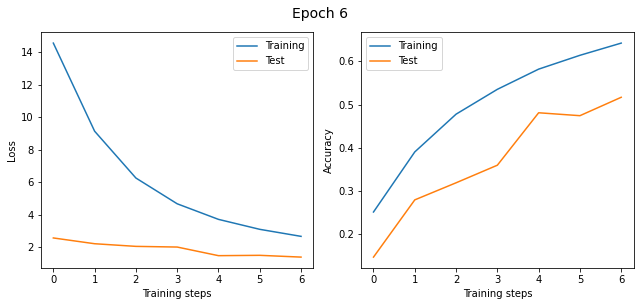

Epoch 7
2020-12-09 15:57:25.693868
Training accuracy: 0.6675031969309463
Test accuracy: 0.5533030063291139
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  74640     
_________________________________________________________________
transition_layer (Transition multiple                  37800     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  103536    
________________

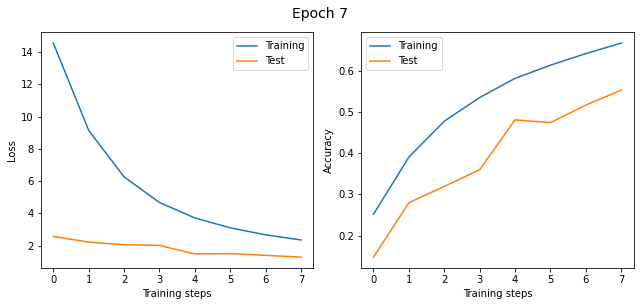

Epoch 8
2020-12-09 15:58:48.868598
Training accuracy: 0.6889186381074168
Test accuracy: 0.6131329113924051
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  74640     
_________________________________________________________________
transition_layer (Transition multiple                  37800     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  103536    
________________

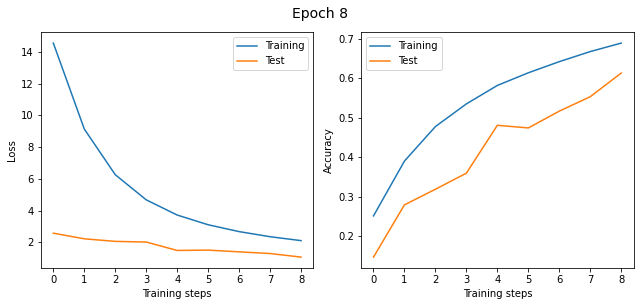

Epoch 9
2020-12-09 16:00:12.074818
Training accuracy: 0.7093430306905371
Test accuracy: 0.6698971518987342
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  74640     
_________________________________________________________________
transition_layer (Transition multiple                  37800     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  103536    
________________

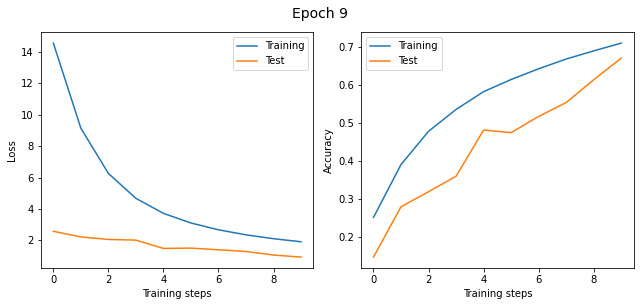

Epoch 10
2020-12-09 16:01:35.459159
Training accuracy: 0.7244285485933504
Test accuracy: 0.6668314873417721
Epoch 11
2020-12-09 16:02:58.395351
Training accuracy: 0.7404411764705882
Test accuracy: 0.696004746835443
Epoch 12
2020-12-09 16:04:21.018731
Training accuracy: 0.7522018861892582
Test accuracy: 0.6790941455696202
Epoch 13
2020-12-09 16:05:43.849551
Training accuracy: 0.7633152173913044
Test accuracy: 0.674940664556962
Epoch 14
2020-12-09 16:07:06.654922
Training accuracy: 0.7732097186700767
Test accuracy: 0.7123219936708861
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dropout (Dropout)            multiple          

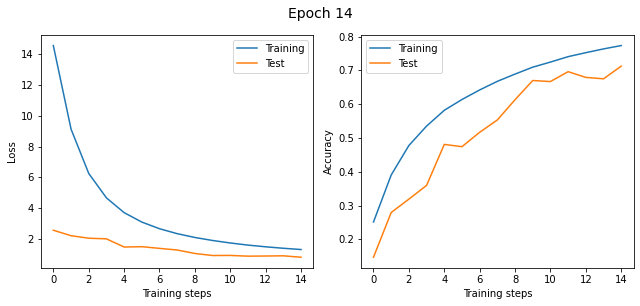

Epoch 15
2020-12-09 16:08:29.923469
Training accuracy: 0.7815057544757034
Test accuracy: 0.7297270569620253
Epoch 16
2020-12-09 16:09:52.868531
Training accuracy: 0.7924112851662404
Test accuracy: 0.7232001582278481
Epoch 17
2020-12-09 16:11:15.640379
Training accuracy: 0.7979899296675192
Test accuracy: 0.7407041139240507
Epoch 18
2020-12-09 16:12:38.485514
Training accuracy: 0.8050471547314578
Test accuracy: 0.7139042721518988
Epoch 19
2020-12-09 16:14:01.365196
Training accuracy: 0.8090113491048594
Test accuracy: 0.7071795886075949
Epoch 20
2020-12-09 16:15:24.070395
Training accuracy: 0.813858695652174
Test accuracy: 0.6805775316455697
Epoch 21
2020-12-09 16:16:46.998491
Training accuracy: 0.8166640025575448
Test accuracy: 0.7159810126582279
Epoch 22
2020-12-09 16:18:09.852801
Training accuracy: 0.8218110613810742
Test accuracy: 0.7593947784810127
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape           

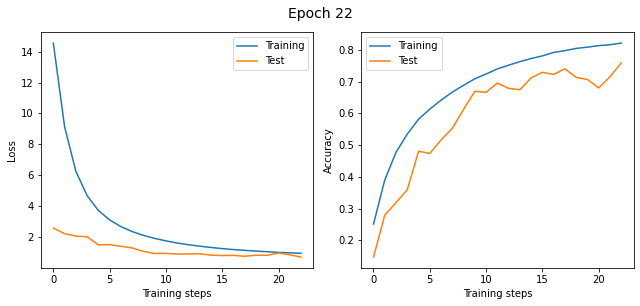

Epoch 23
2020-12-09 16:19:32.857192
Training accuracy: 0.8265984654731457
Test accuracy: 0.6510087025316456
Epoch 24
2020-12-09 16:20:55.763906
Training accuracy: 0.8314857736572889
Test accuracy: 0.7996439873417721
Epoch 25
2020-12-09 16:22:18.569619
Training accuracy: 0.8347706202046036
Test accuracy: 0.7297270569620253
Epoch 26
2020-12-09 16:23:41.300810
Training accuracy: 0.8368765984654731
Test accuracy: 0.7901503164556962
Epoch 27
2020-12-09 16:25:04.672629
Training accuracy: 0.8413403132992328
Test accuracy: 0.779568829113924
Epoch 28
2020-12-09 16:26:27.897758
Training accuracy: 0.8413083439897698
Test accuracy: 0.7818433544303798
Epoch 29
2020-12-09 16:27:51.251628
Training accuracy: 0.8436181265984655
Test accuracy: 0.801621835443038
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_____________________________

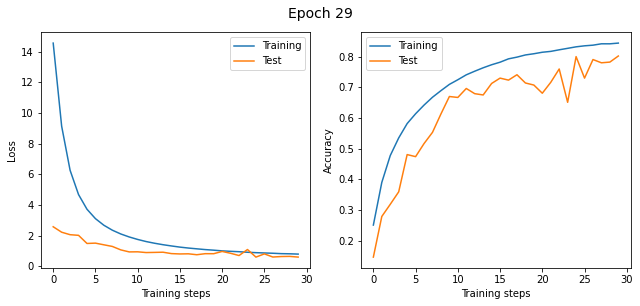

Epoch 30
2020-12-09 16:29:14.959877
Training accuracy: 0.8476902173913042
Test accuracy: 0.7641416139240507
Epoch 31
2020-12-09 16:30:37.944227
Training accuracy: 0.850735294117647
Test accuracy: 0.7769976265822784
Epoch 32
2020-12-09 16:32:01.108460
Training accuracy: 0.8497802109974425
Test accuracy: 0.731309335443038
Epoch 33
2020-12-09 16:33:23.377063
Training accuracy: 0.8561301150895141
Test accuracy: 0.7928204113924051
Epoch 34
2020-12-09 16:34:45.577209
Training accuracy: 0.8581761508951407
Test accuracy: 0.8043908227848101
Epoch 35
2020-12-09 16:36:07.858796
Training accuracy: 0.8593390345268541
Test accuracy: 0.8144778481012658
Epoch 36
2020-12-09 16:37:29.935104
Training accuracy: 0.860733695652174
Test accuracy: 0.7419897151898734
Epoch 37
2020-12-09 16:38:52.206627
Training accuracy: 0.8622842071611253
Test accuracy: 0.7323971518987342
Epoch 38
2020-12-09 16:40:14.483545
Training accuracy: 0.8662883631713555
Test accuracy: 0.7878757911392406
Epoch 39
2020-12-09 16:41:36.69

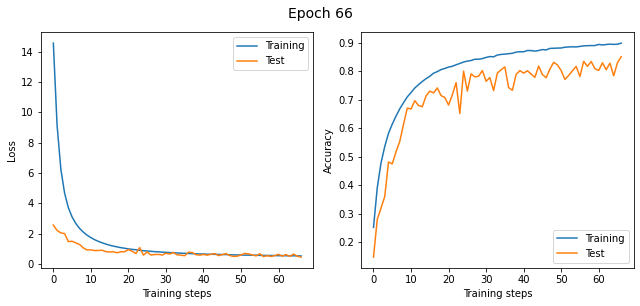

Epoch 67
2020-12-09 17:20:16.572144
Training accuracy: 0.8978300831202046
Test accuracy: 0.8343552215189873
Epoch 68
2020-12-09 17:21:38.775599
Training accuracy: 0.8973505434782608
Test accuracy: 0.8058742088607594
Epoch 69
2020-12-09 17:23:00.814939
Training accuracy: 0.8997282608695651
Test accuracy: 0.728935917721519
Epoch 70
2020-12-09 17:24:22.849407
Training accuracy: 0.900587436061381
Test accuracy: 0.830498417721519
Epoch 71
2020-12-09 17:25:45.187558
Training accuracy: 0.9000359654731458
Test accuracy: 0.8055775316455697
Epoch 72
2020-12-09 17:27:07.315532
Training accuracy: 0.9028892263427111
Test accuracy: 0.8277294303797469
Epoch 73
2020-12-09 17:28:29.384718
Training accuracy: 0.900855179028133
Test accuracy: 0.8195213607594937
Epoch 74
2020-12-09 17:29:51.379244
Training accuracy: 0.9034327046035806
Test accuracy: 0.7759098101265823
Epoch 75
2020-12-09 17:31:13.420873
Training accuracy: 0.9028452685421995
Test accuracy: 0.8276305379746836
Epoch 76
2020-12-09 17:32:35.496

In [9]:
# Description: This part creates objects of a ResNet and DenseNet and executes the training and testing of these models in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
#              In order to better monitor the training progress, the loss and accuracy graphs are provided in addtion to the numerical outputs when the test accuracy 
#              has significantly improved.
tf.keras.backend.clear_session()

num_dense_blocks = 3
list_num_filter =[64, 32, 32, 16, 8]
num_conv_blocks = len(list_num_filter)
growth_rate = 40
model = DenseNet(num_dense_blocks, list_num_filter, growth_rate)   

n_epochs = 90
learning_rate = 0.0001
loss_fn = tf.keras.losses.CategoricalCrossentropy()                    # CategoricalCrossentropy because of 10 labels to differ.
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)    # Optimizer Adam (Adaptive Moment Estimation) with AMSGrad activated.
 


training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

dynamic_threshold_train_visio = 0.5                                    # Test accuracy threshold from which the training progress is displayed.
# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))
    ts_now = dt.datetime.now()
    print(ts_now)

    training_loss, training_accuracy = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_fn, training = False)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print("Training accuracy: " + str(training_accuracy))
    print("Test accuracy: " + str(test_accuracy))

    # Visualization during training to check how the CNN is doing. In 5% steps of the test accuracy starting up from 50% test accuracy.
    if test_accuracy >= dynamic_threshold_train_visio: 
      model.summary()  #!!!find a different place for this!!!

      fig, ax = plt.subplots(1,2, figsize=(9, 4))

      fig.suptitle(('Epoch ' + str(epoch)), fontsize=14, y=1.05)
      line1, = ax[0].plot(training_losses)
      line2, = ax[0].plot(test_losses)
      ax[0].set_xlabel("Training steps")
      ax[0].set_ylabel("Loss")
      ax[0].legend((line1, line2),("Training", "Test"))

      line1, = ax[1].plot(training_accuracies)
      line2, = ax[1].plot(test_accuracies)
      ax[1].set_xlabel("Training steps")
      ax[1].set_ylabel("Accuracy")
      ax[1].legend((line1, line2),("Training", "Test"))

      fig.tight_layout()
      plt.draw()
      plt.show()

      # Increases the test accuracy threshold by 5%.  
      dynamic_threshold_train_visio += 0.05

# **Visualization**

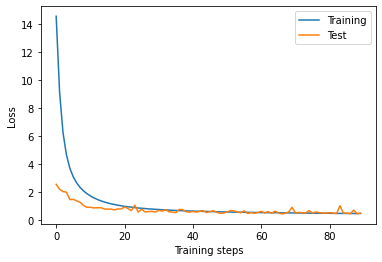

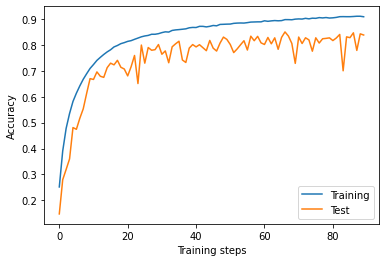

In [10]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the model.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()